# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [8]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:** When running the default agent.py code, the first thing I noticed is that the smartcab doesn't move at all. Looking at the output, I observed that for each step in the simulation, the agent takes an action (in this case idling every step) and receives a numerical reward, typically between -6.0 and 3.0. When the smartcab does something wrong, e.g. idling at a green light with no oncoming traffic, it receives a large negative reward. When it does the correct action like idling at a red light, it receives a (smaller) positive reward. One thing I noticed is that if it idles at a green light with oncoming traffic, it still receives a very small positive reward, most likely because the simulation considers whether the agent is trying to make an unprotected left turn. Another thing to note is that the simulation seems to have disabled the deadline for now.

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:** In the `agent.py` file, one of the flags is `'enforce_deadline'`. This flag enables the deadline metric so that we can see if our agent makes it to the destination on time, and allows us to test its reliability. Another flag is `'num_dummies'`, which sets the number of non-smartcab actors that are in the world, simulating traffic. What's interesting with this flag is that if we add more dummies to the world, it may change the behavior of the smartcab because it would increase the chance of there being oncoming traffic when trying to make an unprotected left turn, and prevent right turns on red lights. This might cause the smartcab to choose different routes (avoiding left turns, say) in order to reach the destination on time. Another flag is `'epsilon'`, the exploration factor, and this determines whether the smartcab will follow its policy or take a random action (with probability epsilon). The default value is set to 1, meaning the smartcab will always take a random action on the first step, but as long as epsilon decays, the smartcab will gradually start following its policy instead of taking random actions.

In `environment.py`, `'Environment.act()'` is called whenever an agent wants to perform an action. This function takes two parameters: the agent that is performing an action, and the action itself. `'Environment.act()'` evaluates whether the action performed is valid or not and assigns a number to the violation variable depending on the severity of illegal actions. It then moves the actor to the new location if the move was valid, and then returns a reward based on the correctness of the action and the severity of the violation if any.

In `simulator.py`, the `'render()'` function graphically displays the simulation using PyGame. The `'render_text()'` function describes the agent's action and reward for each time step as well as the current deadline in text, output to the terminal window. Note that if the display flag in agent.py is set to False, the GUI will be disabled and the `'render()'` function bypassed.

In the `planner.py` file, the `'next_waypoint()'` function considers the East-West direction before the North-South direction, meaning that the planner will prefer to go in the East-West direction before going North-South.

-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'Left'` (turn left), `'Right'` (turn right), or `'Forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


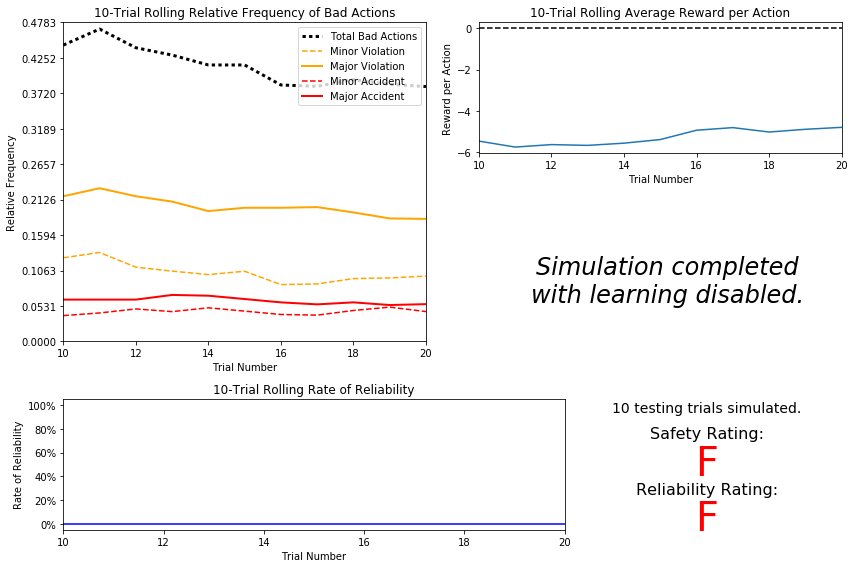

In [2]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliabilty make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:** We can see from the graph mapping the relative frequency of bad actions that the agent performs pretty poorly. The relative frequency of bad actions in total ranges from around 0.38 to 0.47. Around 10% of the actions performed resulted in an accident.

Looking at the graph modeling rate of reliability, we can see that the agent maintains a reliability of 0% throughout all 10 trials. This makes sense given the fact that the agent is driving randomly -- if it ever reaches the destination within the deadline it would have done so through complete chance.

The graph modeling the average reward per action shows that the agent receives a reward of around -5 on average. This suggests that it has been penalized heavily, as if it performed well then we would expect a high positive average reward.

As the number of trials increases, the outcome of the results does not change significantly. This makes sense given the fact that the agent is acting randomly and not learning from its past actions whatsoever. With a learning agent, we would expect to see an improvement over time of the safety and reliability.

These results show that this smartcab should neither be considered safe nor reliable for its passengers. The rate of reliability shows that it never reached its destination in time, and the relative frequency of bad actions shows that it's very unsafe, with each action having around a 10% chance of causing an accident.

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate?*

**Answer:** Almost all of the features in `'inputs'` are most important for learning safety. The agent should only attempt to move forward on a green light, left if there's a green light and no oncoming traffic, and right on a green light or if there's no traffic coming from the left. However, some information is irrelevant. For example, if the agent is trying to make a right turn on a red light, it only cares if the vehicle to the left of it is going to move forward. All the other values that `'left'` can take on can be treated the same. This is an important consideration if we want to reduce the size of our state space.

`'waypoint'` is the most important feature for learning efficiency. This is determined by the smartcab's Planner, and tells the smartcab where to go next in order to reach the destination. Without it, the smartcab would be able to learn how to drive safely, but wouldn't learn how to reach its destination.

I would argue that `'deadline'` is not relevant in this case for safety or efficiency. This is because the deadline is factored into the reward that the primary agent receives via a penalty -- the closer the time is to the deadline, the less reward the agent receives. Furthermore, it would be difficult to define states based on the remaining time, since it is not necessarily bounded.

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the evironment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:** If we used all the features we receive from the `'Environment.sense()'` function besides `'deadline'` to build our set of states, we would get the following number of values for each state:

`'waypoint': 3
'light': 2
'left': 4
'right': 4
'oncoming': 4`

This results in a state space of size 384. This is fairly large considering the fact that training time is polynomial. We can potentially reduce the size of this space by using the values we receive from `'inputs'` to build a set of boolean-valued states that capture only the relevant information that we need to make safe and efficient decisions. The new states would have the following number of possible values:

`'waypoint': 3
'light': 2
'car_left_going_forward': 2
'car_across_going_forward_or_right': 2`

These states capture all the information the smartcab needs to make safe decisions. If it wants to go forward, it only needs to know if the light is green. If it wants to go left, it needs to check if the light is green and if there's an oncoming car either going forward or making a right turn. If it wants to go right, it can do so safely if the light is green and if it's not, then it needs to check if there's a car to the left that is going forward. The size of this state space is 24 -- much better than the previous state space.

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the interative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.01). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

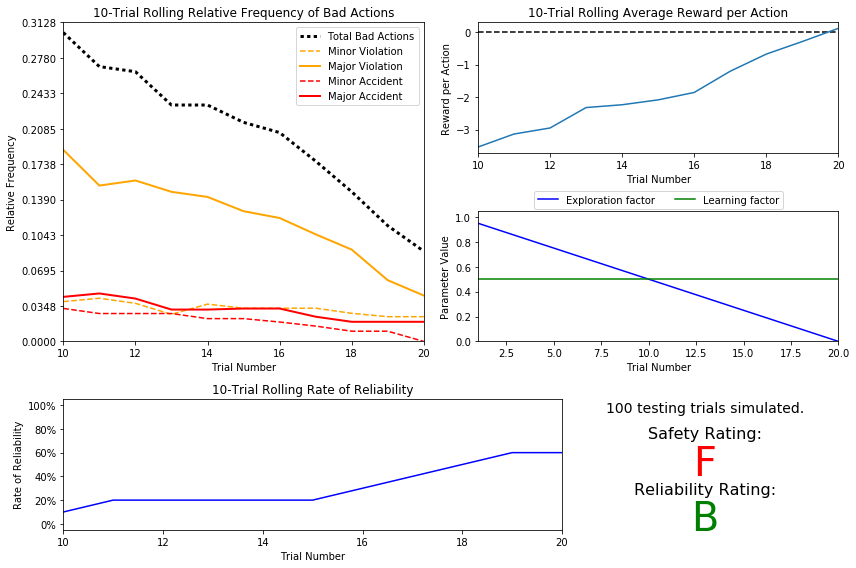

In [7]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:** There really are no similarities between the basic driving agent and the default Q-Learning agent. The basic driving agent performed poorly across the board, and there was no noticeable trend in any of the graphs. Here, we can see a definite improvement over time across all metrics. The relative frequency of bad actions goes down with the number of trials, the reliability goes up, and the average reward per action also goes up.

The driving agent required 20 training trials before testing. This makes sense since we naively set epsilon to decay by 0.05 starting from 1.0 until it fell below the epsilon-tolerance of 0.05. We can see the exploration factor decreasing linearly from 0.95 to 0.0 in the parameters panel, while the learning factor stays constant at 0.5.

The safety and reliability scored an F and B respectively, an improvement over the F's that the basic driving agent scored. However, I must note that 10 testing trials are not enough to accurately give safety and reliability ratings. Previously with 10 testing trials, the first run scored an F in safety and an A in reliability, the second scored an F in safety and a D in reliability, and the third scored an A in safety and an A+ in reliability. This is why I decided to run 100 testing trials instead.

Furthermore, looking at the Q-table, I noticed that quite a few of the states still have 0.0 for the values for some of their actions. This means that the agent never tried those transitions, so we need to tweak the epsilon decay to fill out more of the Q-table.

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the impliciations it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

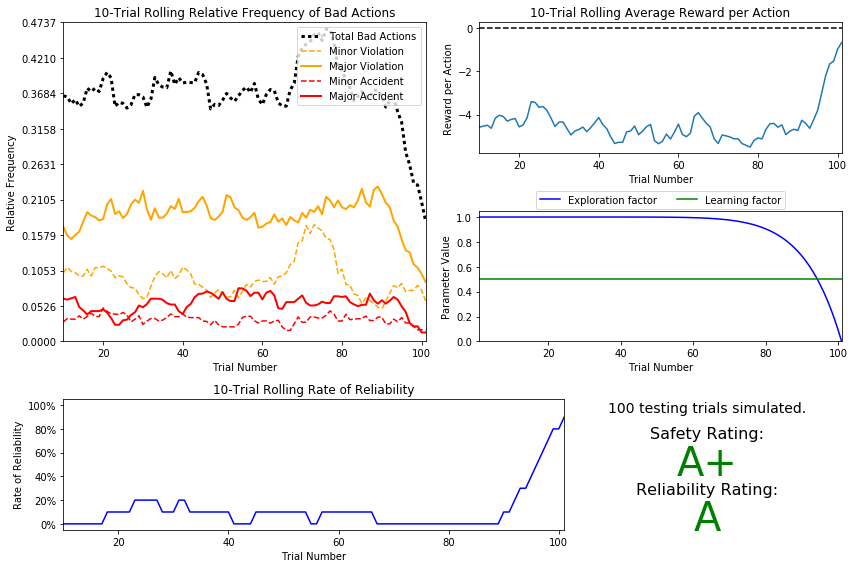

In [6]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:** To improve the Q-Learning simulation, I changed the epsilon decay function to -((0.01 * t) ^ 10) + 1.0. This creates the blue curve in the parameters graph. My intuition behind choosing a function like this is that we want the agent to do as much exploration as possible to flesh out its understanding of the state space, i.e. fill out its Q-table. I wanted a function that caused epsilon to remain close to 1.0 for most of the trials (meaning the agent almost always takes random actions) before sharply decaying towards the end of the training. Note how the graphs for frequency of bad actions, reliability, and average rewards show poor performance for the majority of the initial trials, but then show a huge leap in performance towards the end where epsilon rapidly decays and the agent starts choosing the best actions.

By setting the coefficient of t, I could control how many trials were taken before training. After some experimentation, I decided 100 trials filled out the Q-table enough for the agent to perform well in testing, although there are still some actions in the Q-table that hadn't been explored. This is simply due to the randomness of epsilon-greedy exploration -- no matter how many training trials you run, there's always a chance that some actions will never be explored.

I decided to leave the epsilon-tolerance at 0.05 and the learning rate at 0.5. I saw no reason to change either.

It's clear that this Q-Learner is a huge improvement over the previous Q-Learner, getting an A+ safety rating and an A reliability rating over 100 tests, compared to an F and B respectively for the previous learner. This means that this Q-Learner committed no violations during the testing phase and reached the destination in time for at least 90% of the testing trials. Because of this, I would say that this Q-Learner did learn an appropriate policy for safe and reliable driving. Because I am much more concerned about safety than reliability, and because the smartcab may not have reached its destination in time for certain trials due to circumstances outside its control (like traffic conditions), I am very satisfied with these ratings.

An interesting thing to note is that in order to achieve an A+ safety rating 100% of the time, the agent only needs to have explored all possible bad actions or all possible good actions. This is due to the fact that we initialize new states to have Q-values of 0. In testing, we set epsilon to 0, meaning the agent always takes the action with the highest Q-value. If the agent had explored all possible bad actions, those actions would all have negative Q-values, and the remaining actions are all good and have a Q-value 0 (if unexplored) or greater (if explored). Conversely, if the agent had explored all possible good actions, those actions would all have Q-values greater than 0 and thus the agent would always pick a good action over an unexplored or bad action.

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8
Provide a few examples (using the states you've defined) of what an optimal policy for this problem would look like. Afterwards, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ Provide an example of a state and all state-action rewards recorded, and explain why it is the correct policy.

**Answer:** The following tuple describes the states that I implemented:

`('waypoint', 'light', 'car_left_going_forward', 'car_across_going_forward_or_right')`

where

`car_left_going_forward = inputs['left'] == 'forward'
car_across_going_forward_or_right = inputs['oncoming'] == 'forward' or inputs['oncoming'] == 'right'`

Here are a few examples of optimal policies:

`('forward', 'green', False, False) --> 'forward'
('forward', 'red', False, False)   -->  None
('left', 'green', True, False)     --> 'left'
('left', 'green', True, True)      -->  None
('right', 'red', False, True)      --> 'right'
('right', 'red', True, False)      -->  None`

Here is an example from the Q-table that does follow the optimal policy:

`('right', 'red', False, True)
 -- forward : -10.01
 -- right : 2.11
 -- None : 1.37
 -- left : -18.24`
 
This means the smartcab will safely make a right on red when there's no cross traffic.

Here is an example from the Q-table that does not follow the optimal policy:

`('left', 'green', True, True)
 -- forward : 0.56
 -- right : 0.97
 -- None : -5.28
 -- left : -15.13`
 
Normally, if a human wants to make an unprotected left turn, they wait for oncoming traffic to pass before doing so. If it's a one-lane road and there are cars behind this person that want to go straight, they are supposed to wait for this person to make the left turn. What the smartcab learned to do is if it was supposed to make a left turn, the light was green, and there was oncoming traffic, it would instead make a right turn. This is because the reward system punishes the primary agent for idling at a green light regardless of whether it's waiting for oncoming traffic to pass or not. Furthermore, this policy offers a reason for why the smartcab sometimes does not reach the destination in time. Going forward would actually be slightly better than making a right turn in this situation, because making a right means the smartcab will have to make a U-turn.
 
Here is one more example from the Q-table that does not follow the optimal policy:
 
 `('right', 'red', False, False)
 -- forward : -17.55
 -- right : 0.93
 -- None : 1.05
 -- left : -9.48`
 
In this situation, the waypoint is to the right, the light is red, but there's no cross traffic. In other words, it's completely safe to make a right on red. However, the smartcab instead chooses to idle, which isn't a violation, but neither is it optimal. Compare this policy to the first example, where again there was an opportunity to make a right on red and the smartcab does so correctly. The only thing that's different between the states is the fact that in this example there's no oncoming traffic across the intersection, which is in fact irrelevant to a human trying to make a right on red.

In conclusion, if we wanted to improve reliability even further, we should look into tweaking the reward system to give higher rewards for following the waypoint safely, and reward idling at a green light if the waypoint lies to the left.

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propogating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:** The first characteristic is how states are initialized. New states are built and added to the Q-table on-the-fly with each time step, rather than the entire state space being initialized at the start of a trial. This means that the smartcab cannot see the rewards for entering states in the future, simply because those states may not exist yet.

The second characteristic is the fact that the destination and starting location of the smartcab change with each trial. Let's say we somehow did include future rewards in the learning algorithm. The smartcab may learn a path to the destination, and the states closer to this destination would be updated with higher rewards. However, if we run a new trial and the destination and starting location change, the smartcab would favor the states that resulted in high rewards from the _previous_ trial, which may not necessarily apply to the _current_ trial. The key is that these states may no longer be optimal for the current trial, and therefore the future discounted rewards are irrelevant and may actually throw off the learning algorithm.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.